In [1]:
import qokit
import numpy as np
from itertools import combinations

# Simulation of QAOA applied to a general problem

In this tutorial, we show to get QAOA objective for a problem that does not have a directly implemented high-level API like LABS or MaxCut. In particular, we will consider the Sherrington-Kirkpatrick (SK) model given by the following objective:
$$
G(z) = -\sum_{1\leq i <j\leq N}J^{(N)}_{ij}z_iz_j
$$
where $J^{(N)}_{ij} \sim \mathcal{N}(\mu(N), \sigma^2)$.

To simulate the QAOA on SK model, we need to generate a problem representation. The format used by QOKit is a of tuples, where each tuple defines a summand and contains indices of the Pauli Zs in the product along with the coefficient. For example, if terms = [(0.5, (0,1)), (-1, (0,1,2,3)), (1,(1,2))], the Hamiltonian is
$$
0.5z_0z_1 - z_0z_1z_2z_3 + z_1z_2
$$

In [2]:
N = 4
np.random.seed(10)
terms = [(np.random.normal(), spin_pair) for spin_pair in combinations(range(N), r=2)]

## Create simulator

`simclass` is a class that you should use to create the simulator.
There are multiple simulators in `qokit.fur` module.
You can choose to use `gpu` or `python` simulator and the following notebook should run without error

In [3]:
simclass = qokit.fur.choose_simulator(name='auto')
sim = simclass(N, terms=terms)

In [4]:
### Get precomputed diagonal cost vector and cache if desired

In [4]:
sim.get_cost_diagonal()

array([ 0.39433175, -0.60859862, -3.49474551,  0.82867014,  0.42071262,
        2.27889815, -3.50190003,  3.68263151,  3.68263151, -3.50190003,
        2.27889815,  0.42071262,  0.82867014, -3.49474551, -0.60859862,
        0.39433175])

## Simulate QAOA for parameters

Simulator returns a `result` object which may be different depending on the type of simulator you use.
If you want to use it directly, you have to know exactly which simulator you are using

In [5]:
p = 3
gamma, beta = np.random.rand(2, 3)
_result = sim.simulate_qaoa(gamma, beta) # Result depends on the type of simulator. 

## Get simulation results

### Get statevector

In [6]:
sv = sim.get_statevector(_result)
sv

array([0.13720186+0.14502526j, 0.09431783+0.12211294j,
       0.04665999-0.1383308j , 0.16514588+0.16112639j,
       0.15497791+0.17550594j, 0.26061719+0.187216j  ,
       0.03410968-0.17167419j, 0.36219128+0.20537478j,
       0.36219128+0.20537478j, 0.03410968-0.17167419j,
       0.26061719+0.187216j  , 0.15497791+0.17550594j,
       0.16514588+0.16112639j, 0.04665999-0.1383308j ,
       0.09431783+0.12211294j, 0.13720186+0.14502526j])

### Get probabilities

The simulator will calculate probabilities for you. This may be done in-place, overwriting the data of statevector to avoid allocation of a separate array

In [7]:
probs = sim.get_probabilities(_result)
probs.sum()

1.0000000000000004

This will overwrite the `_result` if using GPU simulation. Subsequent calls to `get_statevector` return invalid data.

In [8]:
probs = sim.get_probabilities(_result, preserve_state=False)
sv2 = sim.get_statevector(_result)
print("Using numpy") if np.allclose(sv, sv2) else print("Yohoo, I'm using a memory-economic simulator!")

Using numpy


### Get expectation value

For numpy version, the simulator effectively does `sv.dot(costs)`, where costs is the precomputed diagonal.

You may specify your own observable vector which will be used instead of the diagonal hamiltonian.

In [9]:
e = sim.get_expectation(_result)
costs_inv = 1/sim.get_cost_diagonal()
e_inv = sim.get_expectation(_result, costs=costs_inv)
print("Expectation of C:", e)
print("1/(Expectation of 1/C): ", 1/e_inv)

Expectation of C: 1.5194551853006746
1/(Expectation of 1/C):  1.4973912754030274


### Get overlap

Returns the overlap with ground states, which are states corresponding to minimum of C. 
You may specify the corresponding costs as well. Additionally, prodive `indices` if you want to get probability for particular state.

In [10]:
overlap = sim.get_overlap(_result)
print("Ground state overlap:", overlap)
# Below we test that for positive-valued cost function, the maximum can be achieved 
# by either inverting the values, or negating the values.
costs_abs = np.abs(sim.get_cost_diagonal())
print("Overlap with ground state for absolute cost:", sim.get_overlap(_result, costs=costs_abs))
overlap_inv = sim.get_overlap(_result, costs=1/costs_abs)
print("Overlap with highest state (inverted costs):", overlap_inv)
overlap_neg = sim.get_overlap(_result, costs=-costs_abs)
print("Overlap with highest state (negative):", overlap_neg)
assert overlap_inv == overlap_neg, "You may have values of mixed sign in your cost."

Ground state overlap: 0.06127099876467232
Overlap with ground state for absolute cost: 0.07971335246821881
Overlap with highest state (inverted costs): 0.346722642613863
Overlap with highest state (negative): 0.346722642613863


Overlap may be calculated in-place as well, which may make subsequent calls like `sim.get_expectation()` return incorrect values.
The default behavior is to copy, to provide consistent between simulator types.

If you only need one value for each `result`, you can pass `preserve_state=False` to reduce the memory usage.

In [11]:
# specify state indices
overlap_03 = sim.get_overlap(_result, indices=[0, 3])
probs = sim.get_probabilities(_result)
assert overlap_03 == probs[[0, 3]].sum(), "This is a bug, please report it"

---

Optimal Solution: 0001110 - 11.0
Initial Gamma: [0.36371077 0.57019677 0.43860151]
Initial Beta: [0.98837384 0.10204481 0.20887676]
Initial Objective: 8.520564627192297

Time to optimize: 0.646026611328125 seconds

Final Gamma: [0.61931824 0.95928749 1.04450547]
Final Beta: [0.40091129 0.26506131 0.21840364]
Final Objective: 10.163584909799939

0001110 (11) - 0.07998164953481125
0101110 (11) - 0.12179647049564608
1010001 (11) - 0.12179647049564608
1110001 (11) - 0.07998164953481125



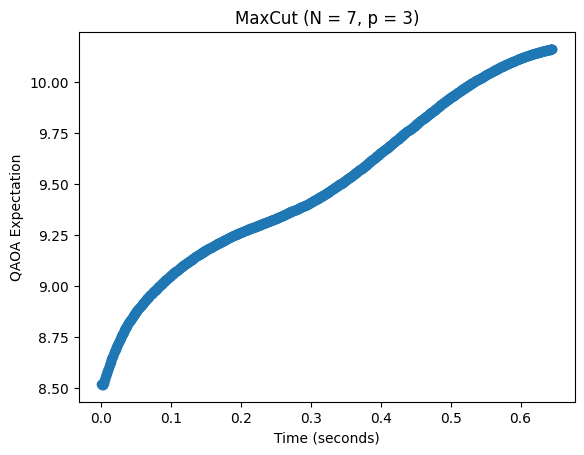

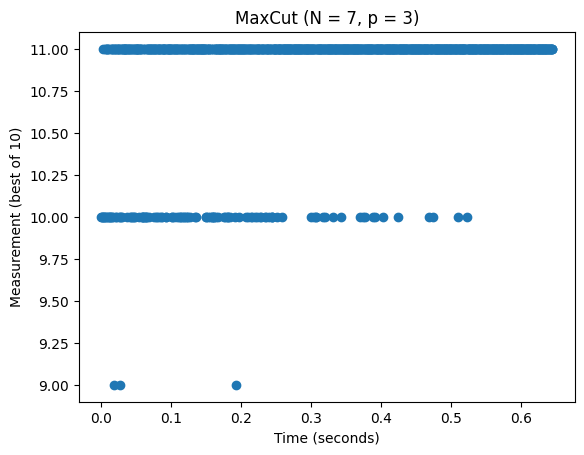

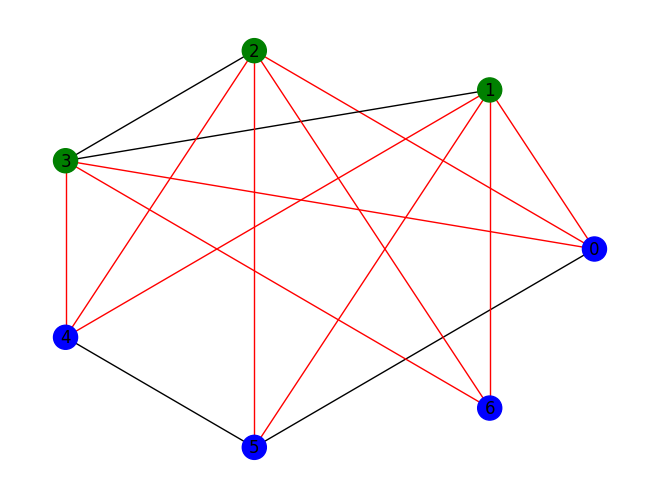

In [1]:
#The code provided by Nadav in the morning on 1st July.

import qokit
import numpy as np
from itertools import combinations
import scipy
import networkx as nx
import time
from matplotlib import pyplot as plt

def compute_graph_colors(G, solution_index):
    N = G.number_of_nodes()
    vert_colors = list(map(lambda c : "green" if c == '1' else "blue", f"{int(solution_index):0{N}b}"))
    vert_colors.reverse()
    edge_colors = [("red" if vert_colors[u] != vert_colors[v] else "black") for u,v in G.edges()]
    return (vert_colors, edge_colors)

def print_result(N, terms, gamma, beta, adjective = ""):
    p = len(gamma)
    print(f"{adjective}Gamma: {gamma}")
    print(f"{adjective}Beta: {beta}")
    print(f"{adjective}Objective: {-inv_max_cut_objective(N, p, terms)(np.hstack([gamma, beta]))}")
    print()

def print_probabilities(G, terms, gamma, beta, threshold = 0, only_likely = False, include_cost = True):
    N = G.number_of_nodes()
    probs = get_probabilities(N, terms, gamma, beta)
    for element in np.column_stack((np.array(range(2**N)), probs)):
        [index, prob] = element
        likely_str = ""
        if (prob > threshold):
            likely_str = " <- Likely outcome"

        cost_str = ""
        if (include_cost):
            contained_verts = list(map(lambda c : c == '1', f"{int(index):0{N}b}"))
            contained_verts.reverse()
            cut_count = evaluate_cut(G, contained_verts)
            cost_str = f" ({cut_count})"

        if (not only_likely):
            print(f"{int(index):0{N}b}{cost_str} - {prob}{likely_str}")
        else:
            if (prob > threshold):
                print(f"{int(index):0{N}b}{cost_str} - {prob}")

def print_state_vector(G, terms, gamma, beta, include_cost = True):
    N = G.number_of_nodes()
    sv = get_state_vector(N, terms, gamma, beta)
    for element in np.column_stack((np.array(range(2**N)), sv)):
        [index, amplitude] = element
        cost_str = ""
        if (include_cost):
            contained_verts = list(map(lambda c : c == '1', f"{int(index):0{N}b}"))
            contained_verts.reverse()
            cut_count = evaluate_cut(G, contained_verts)
            cost_str = f" ({cut_count})"
        
        print(f"{int(index):0{N}b}{cost_str} - {amplitude}")

def plot_expectation(expectations, N, p, start_time):
    def make_time_relative(input):
        time, expectation = input
        return (time - start_time, expectation)

    time_relative_expectations = list(map(make_time_relative, expectations))
    plt.scatter(*zip(*time_relative_expectations))
    plt.title(f"MaxCut (N = {N}, p = {p})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("QAOA Expectation")
    plt.show()

# TODO: Create plot with both expectation and measurements
def plot_measurements(measurements, N, p, start_time):
    def make_time_relative(input):
        time, measurement = input
        return (time - start_time, measurement)

    time_relative_measurements = list(map(make_time_relative, measurements))
    plt.scatter(*zip(*time_relative_measurements))
    plt.title(f"MaxCut (N = {N}, p = {p})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Measurement (best of 10)")
    plt.show()

def random_graph(N, prob_connect = 0.7):
    A = np.random.choice([0, 1], (N, N), p=[1 - prob_connect, prob_connect])
    np.fill_diagonal(A, 0)  # No self-loops
    A = np.triu(A)  # Use only the upper triangle
    A += A.T  # Make the matrix symmetric
    return (A, nx.from_numpy_array(A))

def max_cut_terms_for_graph(G):
    return list(map((lambda edge : (-0.5, edge)), G.edges)) + [((G.number_of_edges()/2.0), ())]

def optimal_solution_with_index(sim):
    costs = sim.get_cost_diagonal()
    solution = max(costs)
    solution_index = np.where(costs == solution)[0][0]
    return (solution, solution_index)

def evaluate_cut(G, bool_verts):
    cuts = 0
    for (u, v) in G.edges():
        if (bool_verts[u] != bool_verts[v]):
            cuts += 1
    return cuts

def get_simulator(N, terms, sim_or_none = None):
    if (sim_or_none is None):
        simclass = qokit.fur.choose_simulator(name='auto')
        return simclass(N, terms=terms)
    else:
        return sim_or_none
    
def get_result(N, terms, gamma, beta, sim = None, result = None):
    if (result is None):
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result
    
def get_simulator_and_result(N, terms, gamma, beta, sim = None, result = None):
    simulator = get_simulator(N, terms, sim)
    if (result is None):
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)

def get_probabilities(N, terms, gamma, beta, sim = None, result = None):
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state = True)

def get_expectation(N, terms, gamma, beta, sim = None, result = None):
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state = True)

def get_state_vector(N, terms, gamma, beta):
    simclass = qokit.fur.choose_simulator(name='auto')
    sim = simclass(N, terms=terms)
    _result = sim.simulate_qaoa(gamma, beta)
    return sim.get_statevector(_result)

def inv_max_cut_objective(N, p, terms, expectations = None, measurements = None, sim = None):
    def f(*args):
        gamma, beta = args[0][:p], args[0][p:]
        current_time = time.time()
        simulator = get_simulator(N, terms, sim)
        probs = get_probabilities(N, terms, gamma, beta, sim)
        costs = simulator.get_cost_diagonal()
        expectation = np.dot(costs, probs)

        if (expectations != None):
            expectations.append((current_time, expectation))

        if (measurements != None):
            measurement = max(np.random.choice(costs, 10, p=probs))
            measurements.append((current_time, measurement))
        
        return -expectation
    return f

def optimize(N, terms, init_gamma, init_beta, expectations = None, measurements = None, sim = None):
    if  (expectations != None):
        expectations.clear()
    if (measurements != None):
        measurements.clear()
    
    p = len(init_gamma)
    assert len(init_beta) == p, "Gamma and Beta must have the same length"
    init_freq = np.hstack([init_gamma, init_beta])

    res = scipy.optimize.minimize(inv_max_cut_objective(N, p, terms, expectations, measurements, sim), init_freq, method = 'COBYLA', options={'rhobeg': 0.01/N})

    gamma, beta = res.x[:p], res.x[p:]
    return (gamma, beta)

# TODO: Compare to randomly trying cuts (and keeping best)
def run_experiment(seed, N, p):
    np.random.seed(seed)
    (A, G) = random_graph(N, 0.5) 
    terms = max_cut_terms_for_graph(G)
    sim = get_simulator(N, terms)
    expectations = []
    measurements = []

    solution, solution_index = optimal_solution_with_index(sim)
    print(f"Optimal Solution: {solution_index:0{N}b} - {solution}")
    vert_colors, edge_colors = compute_graph_colors(G, solution_index)

    init_gamma, init_beta = np.random.rand(2, p)
    print_result(N, terms, init_gamma, init_beta, "Initial ")

    start_time = time.time()
    gamma, beta = optimize(N, terms, init_gamma, init_beta, expectations, measurements, sim)
    end_time = time.time()
    print(f"Time to optimize: {end_time - start_time} seconds\n")

    print_result(N, terms, gamma, beta, "Final ")
    print_probabilities(G, terms, gamma, beta, threshold=0.5/N, only_likely=True)
    print()
    plot_expectation(expectations, N, p, start_time)
    plot_measurements(measurements, N, p, start_time)

    nx.draw(G, nx.circular_layout(G), node_color=vert_colors, edge_color=edge_colors, with_labels=True)

def collect_state_vectors(num_vecs, G, p):
    N = G.number_of_nodes()
    terms = max_cut_terms_for_graph(G)
    qaoa_state_vectors = []

    for _ in range(num_vecs):
        init_gamma, init_beta = np.random.rand(2, p)
        gamma, beta = optimize(N, terms, init_gamma, init_beta)
        qaoa_state_vectors.append(get_state_vector(N, terms, gamma, beta))

    return qaoa_state_vectors
        
#(_, G) = random_graph(N=7)
#collect_state_vectors(10, G, p=3)
seed = int(input('seed = '))
N = int(input('N = '))
p = int(input('p = '))

run_experiment(seed, N, p)

In [2]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
#←from qiskit import QuantumProgram
from qiskit.visualization import plot_histogram
#←from qiskit.tools.visualization import plot_histogram
import math
def Rx(qc, theta, q):
    qc.rx(theta, q)#←qc.u3(theta, -math.pi/2, math.pi/2, q)
def Rz(qc, phi, q):
    qc.rz(phi, q)#←qc.u1(phi, q)
def Rzz(qc, phi, q1, q2):
    qc.cx(q1, q2)
    Rz(qc, -2.0*phi, q2)
    qc.cx(q1, q2)
'''
def Rx(qci, theta, q):
    qci.u3(theta, -math.pi/2, math.pi/2, q)
def Rz(qci, phi, q):
    qci.u1(phi, q)
def Rzz(qci, phi, q1, q2):
    qci.cx(q1, q2)
    Rz(qci, -2.0*phi, q2)
    qci.cx(q1, q2)
'''
#qp = QuantumProgram()
cn = "Qp12-5"
ns = 2
tm = 10
dt = 0.1
#qr = qp.create_quantum_register("qr", ns)
#cr = qp.create_classical_register("cr", ns)
step = math.floor(tm / dt)
hz = [-1.0, -1.0]
J = -1.0
hx = -1.0
qc = QuantumCircuit(ns, ns)
#←qc = qp.create_circuit(cn, [qr], [cr])
for n in range(ns):
    qc.h(n)
'''
for n in range(0, ns):
    qc.h(qr[n])
'''
for n in range(step): #←for n in range(0, step):
    s = n / step
    for i in range(ns): #←for i in range(0, ns):
        Rx(qc, -2.0*(1-s)*hx*dt, i) #←Rx(qc, -2.0*(1-s)*hx*dt, qr[i])
        Rz(qc, -2.0*s*hz[i]*dt, i) #←Rz(qc, -2.0*s*hz[i]*dt, qr[i])
        for j in range(i+1, ns): #←for j in range(0, ns):
            #←if i < j:
            Rzz(qc, s*J*dt, i, j) #←Rzz(qc, s*J*dt, qr[i], qr[j])
#measurement
for n in range(ns): #←for n in range(0, ns):
    qc.measure(n, ns-1-n) #←qc.measure(qr[ns-1-n], cr[n]) 

#using the simulator
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit, shots = 1000)
result = execute(qc, simulator, shots=1000).result()

#display the outcome
counts = result.get_counts()
print(counts)
plot_histogram(counts)
'''
r = qp.execute(cn, timeout = 600, shots = 1000)
print(r.get_data(cn))
plot_histogram(r.get_counts(cn))
'''

{'01': 1, '00': 999}


'\nr = qp.execute(cn, timeout = 600, shots = 1000)\nprint(r.get_data(cn))\nplot_histogram(r.get_counts(cn))\n'

{'10': 1, '00': 999}


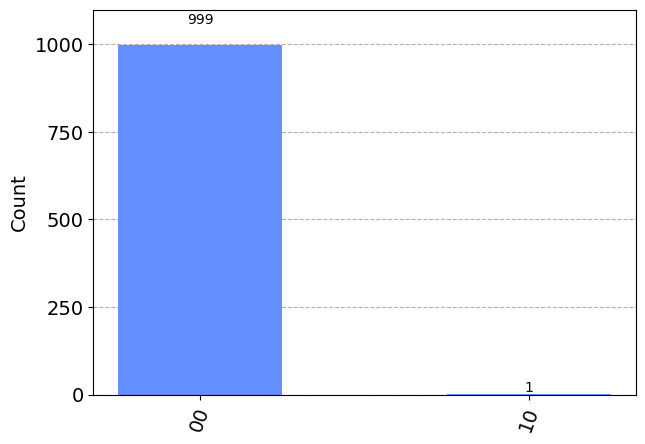

In [3]:
#イジングハミルトニアンの断熱量子計算ゲートの基本プロトタイプ: Basic prototype of an adiabatic quantum computation gate for Ising Hamiltonian.

from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import math

def Rx(qc, theta, q):
    qc.rx(theta, q)

def Rz(qc, phi, q):
    qc.rz(phi, q)

def Rzz(qc, phi, q1, q2):
    qc.cx(q1, q2)
    Rz(qc, -2.0 * phi, q2)
    qc.cx(q1, q2)

# 定数設定
cn = "Qp12-5"
ns = 2
tm = 10
dt = 0.1
step = math.floor(tm / dt)
hz = [-1.0, -1.0]
J = -1.0
hx = -1.0

# 量子回路の作成
qc = QuantumCircuit(ns, ns)
for n in range(ns):
    qc.h(n)

for n in range(step):
    s = n / step
    for i in range(ns):
        Rx(qc, -2.0 * (1-s) * hx * dt, i)
        Rz(qc, -2.0 * s * hz[i] * dt, i)
        for j in range(i+1, ns):
            Rzz(qc, s * J * dt, i, j)

# 測定
for n in range(ns):
    qc.measure(n, ns-1-n)

# シミュレータの使用
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit, shots=1000)
result = execute(qc, simulator, shots=1000).result()

# 結果の表示
counts = result.get_counts()
print(counts)
plot_histogram(counts)


{'01': 1, '11': 502, '00': 497}


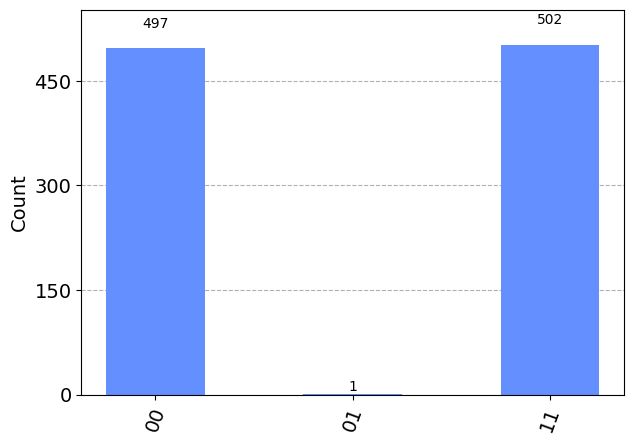

In [4]:
#結合定数Jが負でのスピン整列: Spin alignment with negative coupling constant J

from qiskit import QuantumCircuit, Aer, transpile, assemble, execute #←from qiskit import QuantumProgram
from qiskit.visualization import plot_histogram #←from qiskit.tools.visualization import plot_histogram
import math
def Rx(qci, theta, q):
    qc.rx(theta, q) #←qci.u3(theta, -math.pi/2, math.pi/2, q)
def Rz(qc, phi, q):
    qc.rz(phi, q)
def Rzz(qci, phi, q1, q2):
    qc.cx(q1, q2) #←qci.cx(q1, q2)
    Rz(qci, -2.0*phi, q2)
    qc.cx(q1, q2) #←qci.cx(q1, q2)
#qp = QuantumProgram()
cn = "Qp12-6"
ns = 2
tm = 10
dt = 0.1
step = math.floor(tm / dt)
J = -1.0
hx = -1.0
#qr = qp.create_quantum_register("qr", ns)
#cr = qp.create_classical_register("cr", ns)

#making quantum circuits
qc = QuantumCircuit(ns, ns) #←qc = qp.create_circuit(cn, [qr], [cr])
for n in range(ns): #←for n in range(0, ns):
    qc.h(n) #←qc.h(qr[n])
#step = math.floor(tm/dt)
#J = -1.0
#hx = -1.0
for n in range(step): #←for n in range(0, step):
    s = n / step
    for i in range(ns): #←for i in range(0, ns):
        Rx(qc, -2.0*(1-s)*hx*dt, i) #←Rx(qc, -2.0*(1-s)*hx*dt, qr[i])
        for j in range(i+1, ns): #←for j in range(0, ns):
            #if i < j:
                Rzz(qc, s*J*dt, i, j) #←Rzz(qc, s*J*dt, qr[i], qr[j])

#measurement
for n in range(ns): #←for n in range(0, ns):
    qc.measure(n, ns-1-n)#←qc.measure(qr[ns-1-n], cr[n])

#using the simulator
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit, shots = 1000)
result = execute(qc, simulator, shots = 1000).result()
#r = qp.execute(cn, timeout = 600, shots = 1000)

#display the outcome
counts = result.get_counts()
print(counts)
plot_histogram(counts)
#print(r.get_data(cn))
#plot_histogram(r.get_counts(cn))

Optimal Solution: 0011100001 - 14.0
Initial Gamma: [0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
Initial Beta: [0.64589411 0.43758721 0.891773   0.96366276 0.38344152]
Initial Objective: 9.041020710936072

Time to optimize: 11.032957315444946 seconds

Final Gamma: [0.29720489 0.75502796 0.91658583 0.29173137 0.86131943]
Final Beta: [0.69323172 0.39195683 0.52952707 1.17254757 0.3054454 ]
Final Objective: 12.584376811075494




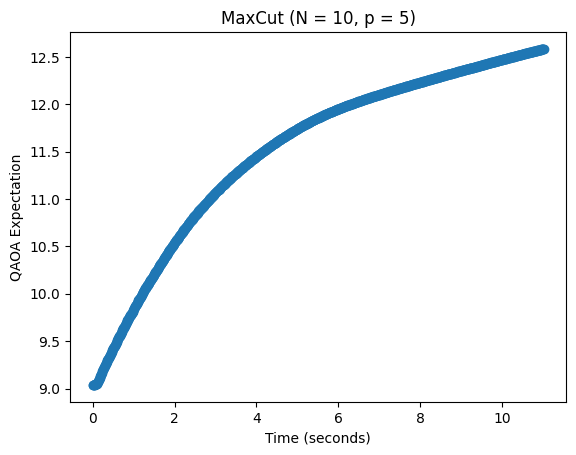

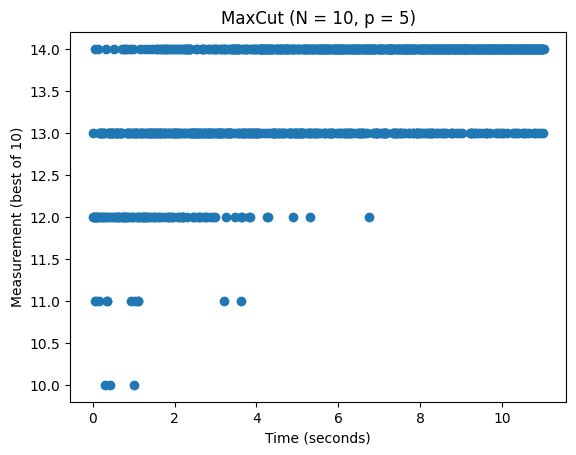

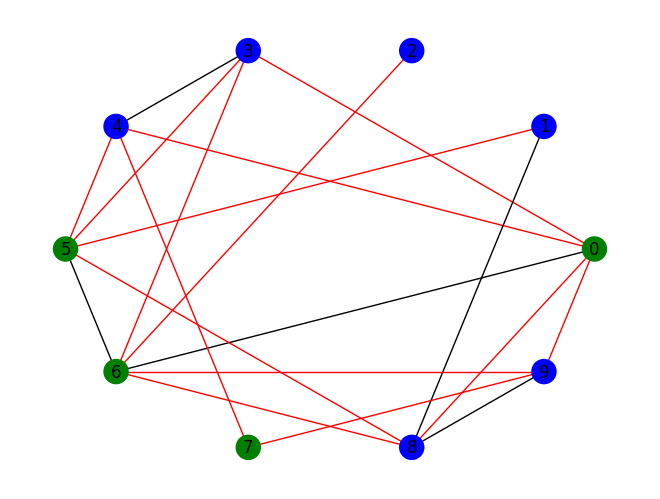

In [5]:
#The code provided by Nadav in the evening on 1st July.

import typing
import qokit
import numpy as np
import scipy
import networkx as nx
import time
from matplotlib import pyplot as plt
from qokit.fur.qaoa_simulator_base import QAOAFastSimulatorBase, TermsType
import qokit.maxcut as mc


def compute_graph_colors(G: nx.Graph, solution_index: int) -> tuple[list[str], list[str]]:
    N = G.number_of_nodes()
    vert_colors = list(map(lambda c: "green" if c == "1" else "blue", f"{int(solution_index):0{N}b}"))
    vert_colors.reverse()
    edge_colors = [("red" if vert_colors[u] != vert_colors[v] else "black") for u, v in G.edges()]
    return (vert_colors, edge_colors)


def print_result(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, adjective: str = "") -> None:
    p = len(gamma)
    print(f"{adjective}Gamma: {gamma}")
    print(f"{adjective}Beta: {beta}")
    print(f"{adjective}Objective: {-inv_max_cut_objective(N, p, terms)(np.hstack([gamma, beta]))}")
    print()


def evaluate_cut(G: nx.Graph, bool_verts: list[bool]) -> int:
    cuts = 0
    for u, v in G.edges():
        if bool_verts[u] != bool_verts[v]:
            cuts += 1
    return cuts


def print_probabilities(
    G: nx.Graph, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, threshold: float = 0, only_likely: bool = False, include_cost: bool = True
) -> None:
    N = G.number_of_nodes()
    probs = get_probabilities(N, terms, gamma, beta)
    for element in np.column_stack((np.array(range(2**N)), probs)):
        [index, prob] = element
        likely_str = ""
        if prob > threshold:
            likely_str = " <- Likely outcome"

        cost_str = ""
        if include_cost:
            contained_verts = list(map(lambda c: c == "1", f"{int(index):0{N}b}"))
            contained_verts.reverse()
            cut_count = evaluate_cut(G, contained_verts)
            cost_str = f" ({cut_count})"

        if not only_likely:
            print(f"{int(index):0{N}b}{cost_str} - {prob}{likely_str}")
        else:
            if prob > threshold:
                print(f"{int(index):0{N}b}{cost_str} - {prob}")


def print_state_vector(G: nx.Graph, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, include_cost: bool = True) -> None:
    N = G.number_of_nodes()
    sv = get_state_vector(N, terms, gamma, beta)
    for element in np.column_stack((np.array(range(2**N)), sv)):
        [index, amplitude] = element
        cost_str = ""
        if include_cost:
            contained_verts = list(map(lambda c: c == "1", f"{int(index):0{N}b}"))
            contained_verts.reverse()
            cut_count = evaluate_cut(G, contained_verts)
            cost_str = f" ({cut_count})"

        print(f"{int(index):0{N}b}{cost_str} - {amplitude}")


def plot_expectation(expectations: list[float], N: int, p: int, start_time: float) -> None:
    def make_time_relative(input: tuple[float, float]) -> tuple[float, float]:
        time, expectation = input
        return (time - start_time, expectation)

    time_relative_expectations = list(map(make_time_relative, expectations))
    plt.scatter(*zip(*time_relative_expectations))
    plt.title(f"MaxCut (N = {N}, p = {p})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("QAOA Expectation")
    plt.show()


def plot_measurements(measurements: list[float], N: int, p: int, start_time: float) -> None:
    def make_time_relative(input: tuple[float, float]) -> tuple[float, float]:
        time, measurement = input
        return (time - start_time, measurement)

    time_relative_measurements = list(map(make_time_relative, measurements))
    plt.scatter(*zip(*time_relative_measurements))
    plt.title(f"MaxCut (N = {N}, p = {p})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Measurement (best of 10)")
    plt.show()


def optimal_solution_with_index(sim: QAOAFastSimulatorBase) -> tuple[float, int]:
    costs = sim.get_cost_diagonal()
    solution = max(costs)
    solution_index = np.where(costs == solution)[0][0]
    return (solution, solution_index)


def get_simulator(N: int, terms: TermsType, sim_or_none: QAOAFastSimulatorBase | None = None) -> QAOAFastSimulatorBase:
    if sim_or_none is None:
        simclass = qokit.fur.choose_simulator(name="auto")
        return simclass(N, terms=terms)
    else:
        return sim_or_none


def get_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    if result is None:
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result


def get_simulator_and_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> tuple[QAOAFastSimulatorBase, np.ndarray]:
    simulator = get_simulator(N, terms, sim)
    if result is None:
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)


def get_probabilities(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state=True)


def get_expectation(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state=True)


def get_state_vector(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray) -> np.ndarray:
    simclass = qokit.fur.choose_simulator(name="auto")
    sim = simclass(N, terms=terms)
    _result = sim.simulate_qaoa(gamma, beta)
    return sim.get_statevector(_result)


# Evaluates the objective function, and if expectations or measurements is passed in, appends to them
def inv_max_cut_objective(
    N: int, p: int, terms: TermsType, expectations: list[float] | None = None, measurements: list[float] | None = None, sim: QAOAFastSimulatorBase | None = None
) -> typing.Callable:
    def f(*args) -> float:
        gamma, beta = args[0][:p], args[0][p:]
        current_time = time.time()
        simulator = get_simulator(N, terms, sim)
        probs = get_probabilities(N, terms, gamma, beta, sim)
        costs = simulator.get_cost_diagonal()
        expectation = np.dot(costs, probs)

        if expectations != None:
            expectations.append((current_time, expectation))

        if measurements != None:
            measurement = max(np.random.choice(costs, 10, p=probs))
            measurements.append((current_time, measurement))

        return -expectation

    return f


# Given Eising terms and initial parameters, runs scipy.optimize.minimize and returns optimized parameters
# If expectations or measurements is passed in, populates them (this harms runtime)
def optimize(
    N: int,
    terms: TermsType,
    init_gamma: np.ndarray,
    init_beta: np.ndarray,
    expectations: list[float] | None = None,
    measurements: list[float] | None = None,
    sim: QAOAFastSimulatorBase | None = None,
) -> tuple[np.ndarray, np.ndarray]:
    if expectations != None:
        expectations.clear()
    if measurements != None:
        measurements.clear()

    p = len(init_gamma)
    assert len(init_beta) == p, "Gamma and Beta must have the same length"
    init_freq = np.hstack([init_gamma, init_beta])

    res = scipy.optimize.minimize(inv_max_cut_objective(N, p, terms, expectations, measurements, sim), init_freq, method="COBYLA", options={"rhobeg": 0.01 / N})

    gamma, beta = res.x[:p], res.x[p:]
    return (gamma, beta)


# Generates a random graph with N vertices and runs MaxCut QAOA on this graph, plotting results
def run_experiment(seed: int, N: int, p: int) -> None:
    np.random.seed(seed)
    G = nx.erdos_renyi_graph(N, 0.5, seed=seed)  # Random graph w/ 0.5 edge probability
    terms = mc.get_maxcut_terms(G)
    sim = get_simulator(N, terms)
    expectations = []
    measurements = []

    # Compute and print solution by brute force
    solution, solution_index = optimal_solution_with_index(sim)
    print(f"Optimal Solution: {solution_index:0{N}b} - {solution}")
    vert_colors, edge_colors = compute_graph_colors(G, solution_index)

    # Random starting parameters
    init_gamma, init_beta = np.random.rand(2, p)
    print_result(N, terms, init_gamma, init_beta, "Initial ")

    start_time = time.time()
    # If you don't want expectation and measurement plots, do not pass in parameters!
    gamma, beta = optimize(N, terms, init_gamma, init_beta, expectations, measurements, sim)
    end_time = time.time()
    print(f"Time to optimize: {end_time - start_time} seconds\n")

    print_result(N, terms, gamma, beta, "Final ")
    print_probabilities(G, terms, gamma, beta, threshold=0.5 / N, only_likely=True)
    print()
    plot_expectation(expectations, N, p, start_time)
    plot_measurements(measurements, N, p, start_time)

    nx.draw(G, nx.circular_layout(G), node_color=vert_colors, edge_color=edge_colors, with_labels=True)


seed = int(input('seed = '))
N = int(input('N = '))
p = int(input('p = '))

run_experiment(seed, N, p)

{'11': 1, '00': 1, '10': 498, '01': 500}


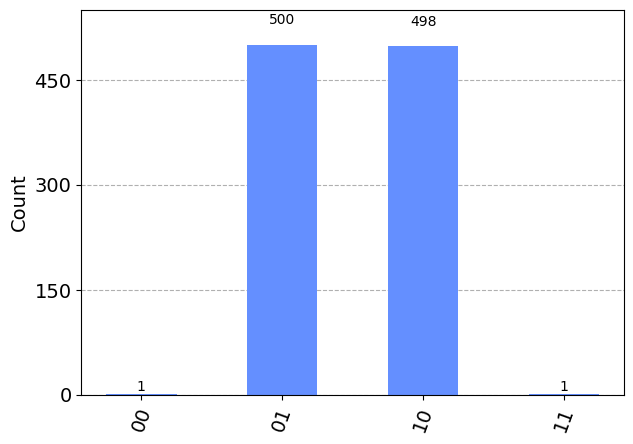

In [6]:
#結合定数Jが正でのスピン整列: Spin alignment with positive coupling constant J

from qiskit import QuantumCircuit, Aer, transpile, assemble, execute #←from qiskit import QuantumProgram
from qiskit.visualization import plot_histogram #←from qiskit.tools.visualization import plot_histogram
import math
def Rx(qci, theta, q):
    qc.rx(theta, q) #←qci.u3(theta, -math.pi/2, math.pi/2, q)
def Rz(qc, phi, q):
    qc.rz(phi, q)
def Rzz(qci, phi, q1, q2):
    qc.cx(q1, q2) #←qci.cx(q1, q2)
    Rz(qci, -2.0*phi, q2)
    qc.cx(q1, q2) #←qci.cx(q1, q2)
#qp = QuantumProgram()
cn = "Qp12-6"
ns = 2
tm = 10
dt = 0.1
step = math.floor(tm / dt)
J = 1.0
hx = -1.0
#qr = qp.create_quantum_register("qr", ns)
#cr = qp.create_classical_register("cr", ns)

#making quantum circuits
qc = QuantumCircuit(ns, ns) #←qc = qp.create_circuit(cn, [qr], [cr])
for n in range(ns): #←for n in range(0, ns):
    qc.h(n) #←qc.h(qr[n])
#step = math.floor(tm/dt)
#J = -1.0
#hx = -1.0
for n in range(step): #←for n in range(0, step):
    s = n / step
    for i in range(ns): #←for i in range(0, ns):
        Rx(qc, -2.0*(1-s)*hx*dt, i) #←Rx(qc, -2.0*(1-s)*hx*dt, qr[i])
        for j in range(i+1, ns): #←for j in range(0, ns):
            #if i < j:
                Rzz(qc, s*J*dt, i, j) #←Rzz(qc, s*J*dt, qr[i], qr[j])

#measurement
for n in range(ns): #←for n in range(0, ns):
    qc.measure(n, ns-1-n)#←qc.measure(qr[ns-1-n], cr[n])

#using the simulator
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit, shots = 1000)
result = execute(qc, simulator, shots = 1000).result()
#r = qp.execute(cn, timeout = 600, shots = 1000)

#display the outcome
counts = result.get_counts()
print(counts)
plot_histogram(counts)
#print(r.get_data(cn))
#plot_histogram(r.get_counts(cn))

{'11': 252, '00': 255, '10': 245, '01': 248}


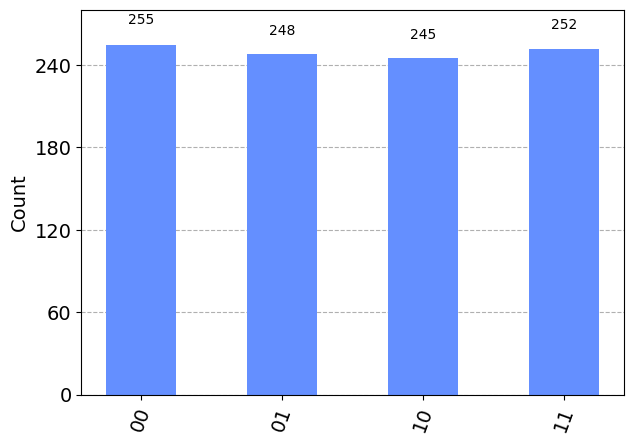

In [12]:
#Adiabatic quantum computing gate of Ising Hamiltonian with a negative coupling constant J and a negative longitudinal magnetic field

from qiskit import QuantumCircuit, Aer, transpile, assemble, execute #←from qiskit import QuantumProgram
from qiskit.visualization import plot_histogram #←from qiskit.tools.visualization import plot_histogram
import math
def Rx(qci, theta, q):
    qc.u(theta, -math.pi/2, math.pi/2, q) #←qci.u3(theta, -math.pi/2, math.pi/2, q)
def Rz(qci, phi, q):
    qc.rz(phi, q) #←qci.u1(phi, q)
def Rzz(qci, phi, q1, q2):
    qc.cx(q1, q2) #←qci.cx(q1, q2)
    Rz(qci, -2.0*phi, q2)
    qc.cx(q1, q2) #←qci.cx(q1, q2)
#qp = QuantumProgram()

#Create a quantum circuit
cn = "Qp12-8"
ns = 2
tm = 10
dt = 0.1
qr = QuantumCircuit(ns, ns)#←qr = qp.create_quantum_register("qr", ns)
#cr = qp.create_classical_register("cr", ns)
#qc = qp.create_circuit(cn, [qr], [cr])

#Apply Hadamard gates to all qubits
for n in range(ns): #←for n in range(0, ns):
    qr.h(n) #←qc.h(qr[n])

step = math.floor(tm/dt)
hz = [-1, -1]
J = -1.0
hx = -1.0
for n in range(step): #←for n in range(0, step):
    s = n / step
    for i in range(ns): #←for i in range(0, ns):
        Rx(qr, -2.0*(1-s)*hx*dt, i)#←Rx(qc, -2.0*(1-s)*hx*dt, qr[i])
        Rz(qr, -2.0*s*hz[i]*dt, i)#←Rz(qc, -2.0*s*hz[i]*dt, qr[i])
        for j in range(ns): #←for j in range(0, ns):
            if i < j:
                Rzz(qc, s*J*dt, i, j) #←Rzz(qc, s*J*dt, qr[i], qr[j])

#Measure all qubits
for n in range(0, ns):
    qr.measure(ns-1-n, n) #←qc.measure(qr[ns-1-n], cr[n])

# Execute the circuit
backend = Aer.get_backend('qasm_simulator')
tqc = transpile(qr, backend)
qobj = assemble(tqc, shots=1000)
result = execute(qr, backend, shots=1000).result()

# Print and plot the result
counts = result.get_counts()
print(counts)
plot_histogram(counts)
#r = qp.execute(cn, timeout = 600, shots = 1000)
#print(r.get_data(cn))
#plot_histogram(r.get_counts(cn))